# Imports


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from collections import Counter
from util import get_common_words
from wordcloud import WordCloud
import scipy.stats as stats
from textstat import textstat


In [2]:

splits = {'train': 'synthetic_text_to_sql_train.snappy.parquet', 'test': 'synthetic_text_to_sql_test.snappy.parquet'}
df = pd.read_parquet("hf://datasets/gretelai/synthetic_text_to_sql/" + splits["train"])


In [3]:
df_add= pd.read_json("hf://datasets/b-mc2/sql-create-context/sql_create_context_v4.json")

In [4]:
real_world_df = pd.read_json("hf://datasets/NoobLoader/sql-query-db/train.jsonl", lines=True)

In [5]:
df = df[['sql_prompt', 'sql_context',  'sql']]
df
df = df.rename(columns={'sql_prompt': 'question', 'sql_context': 'context', 'sql': 'answer'})
df_conc = pd.concat([df, df_add], ignore_index=True)
df_conc

,question,context,answer
0,What is the total volume of timber sold by eac...,"CREATE TABLE salesperson (salesperson_id INT, ...","SELECT salesperson_id, name, SUM(volume) as to..."
1,List all the unique equipment types and their ...,CREATE TABLE equipment_maintenance (equipment_...,"SELECT equipment_type, SUM(maintenance_frequen..."
2,How many marine species are found in the South...,"CREATE TABLE marine_species (name VARCHAR(50),...",SELECT COUNT(*) FROM marine_species WHERE loca...
3,What is the total trade value and average pric...,"CREATE TABLE trade_history (id INT, trader_id ...","SELECT trader_id, stock, SUM(price * quantity)..."
4,Find the energy efficiency upgrades with the h...,"CREATE TABLE upgrades (id INT, cost FLOAT, typ...","SELECT type, cost FROM (SELECT type, cost, ROW..."
...,...,...,...
178572,What time was the match played with a score of...,"CREATE TABLE table_name_35 (time VARCHAR, scor...","SELECT time FROM table_name_35 WHERE score = ""..."
178573,On which ground did the team play Aston Villa?,"CREATE TABLE table_name_83 (ground VARCHAR, op...",SELECT ground FROM table_name_83 WHERE opponen...
178574,What kind of competition was it at San Siro at...,CREATE TABLE table_name_60 (competition VARCHA...,SELECT competition FROM table_name_60 WHERE gr...
178575,What is the total number of decile for the red...,"CREATE TABLE table_name_34 (decile VARCHAR, na...",SELECT COUNT(decile) FROM table_name_34 WHERE ...


# Task 2 
Provide statistical summaries of the data. Please show at least five different types of
summaries, and analysis your findings. Use these observations to learn and communicate (in
your reports) something about the data. Simple examples include number of samples,
attributes, column names, if missing values are present, quartiles etc.

### 1. Attributes

In [6]:
df_conc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178577 entries, 0 to 178576
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   question  178577 non-null  object
 1   context   178577 non-null  object
 2   answer    178577 non-null  object
dtypes: object(3)
memory usage: 4.1+ MB


### 2. Sample of the Data


In [7]:
df.head()

,question,context,answer
0,What is the total volume of timber sold by eac...,"CREATE TABLE salesperson (salesperson_id INT, ...","SELECT salesperson_id, name, SUM(volume) as to..."
1,List all the unique equipment types and their ...,CREATE TABLE equipment_maintenance (equipment_...,"SELECT equipment_type, SUM(maintenance_frequen..."
2,How many marine species are found in the South...,"CREATE TABLE marine_species (name VARCHAR(50),...",SELECT COUNT(*) FROM marine_species WHERE loca...
3,What is the total trade value and average pric...,"CREATE TABLE trade_history (id INT, trader_id ...","SELECT trader_id, stock, SUM(price * quantity)..."
4,Find the energy efficiency upgrades with the h...,"CREATE TABLE upgrades (id INT, cost FLOAT, typ...","SELECT type, cost FROM (SELECT type, cost, ROW..."


### 3. Null Values

In [8]:
null_counts = df_conc.isnull().sum()
print(null_counts)


question    0
context     0
answer      0
dtype: int64


### 4. Duplicated values

In [9]:
duplicated_rows = df_conc.duplicated()
print(duplicated_rows.sum())
print(df_conc[duplicated_rows])


0
Empty DataFrame
Columns: [question, context, answer]
Index: []


### 5. Row Names and unique values

In [10]:
col_names = df_conc.columns
for col in col_names:
    print(f"Unique values in {col} are: {df_conc[col].nunique()} /{len(df_conc)}")


Unique values in question are: 178309 /178577
Unique values in context are: 162713 /178577
Unique values in answer are: 177848 /178577


# Task 3 
Perform exploratory analysis on the data. Research online for ideas, and then show analysis on
at least five different aspects of the dataset. Analyze your findings.
Note: This part is open-ended. Any valid analysis is fine. Use visualizations when necessary.

### 1. IQR of nl question length

In [11]:
df_conc['question_len'] = df_conc['question'].apply(len)
question_len_stats = df_conc['question_len'].describe()
question_len_stats

count    178577.000000
mean         73.256758
std          27.128695
min          10.000000
25%          54.000000
50%          70.000000
75%          88.000000
max         438.000000
Name: question_len, dtype: float64

### 2. IQR of SQL Query Answers

In [12]:
df_conc['sql_len'] = df_conc['answer'].apply(len)
sql_len_stats = df_conc['sql_len'].describe()
sql_len_stats

count    178577.000000
mean        104.751676
std          58.693465
min          16.000000
25%          67.000000
50%          85.000000
75%         124.000000
max         761.000000
Name: sql_len, dtype: float64

### 3. Most common words in NL Questions

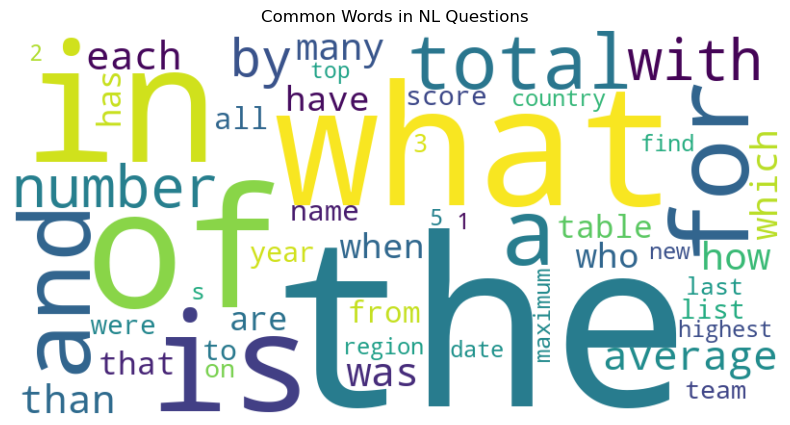

In [13]:

common_words_question = get_common_words(df_conc['question'])
common_words_question
word_freq_nl = dict(common_words_question)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_nl)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in NL Questions")
plt.show()


### 4. Most common words in SQL Answers

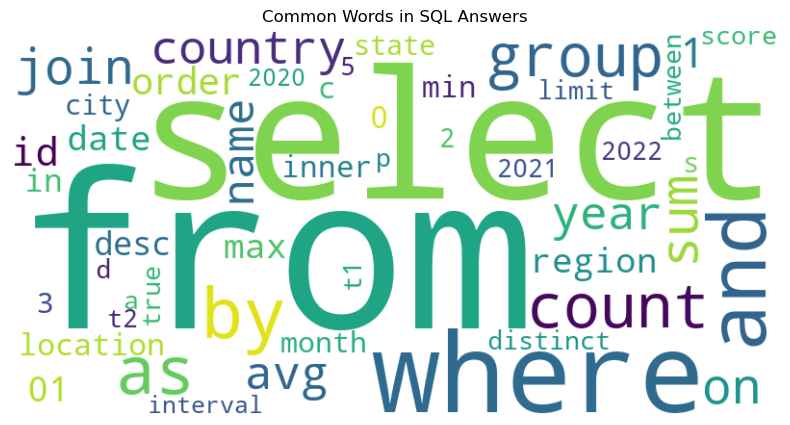

In [14]:
common_words_sql = get_common_words(df_conc['answer'])
common_words_sql
word_freq_sql = dict(common_words_sql)

# Create the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_sql)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in SQL Answers")
plt.show()


### 5.Length distribution

d:\Anaconda\envs\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\envs\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


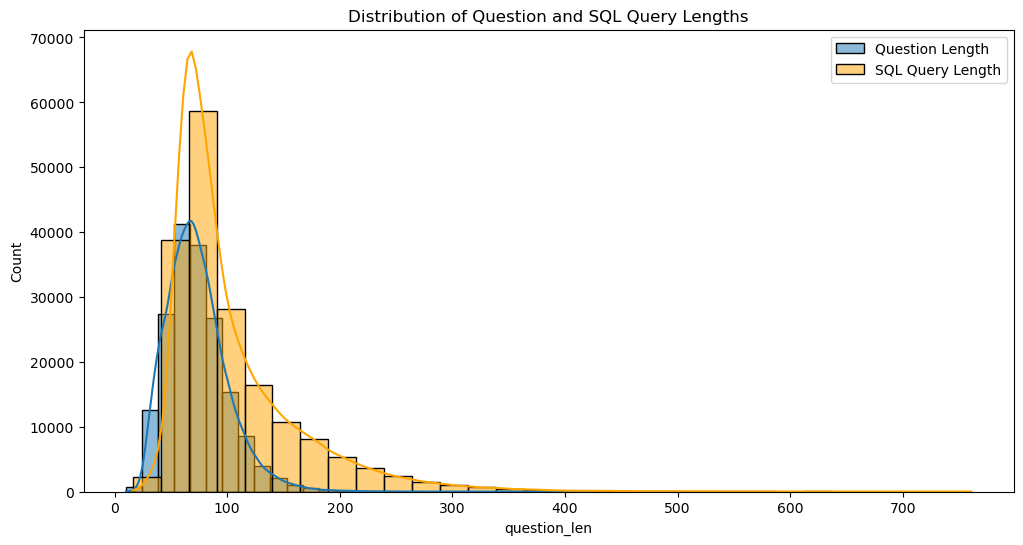

In [15]:
plt.figure(figsize=(12, 6))
sns.histplot(df_conc['question_len'], bins=30, kde=True, label='Question Length')
sns.histplot(df_conc['sql_len'], bins=30, kde=True, label='SQL Query Length', color='orange')
plt.title('Distribution of Question and SQL Query Lengths')
plt.legend()
plt.show()


# Task 4
Perform exploratory analysis to answer questions. Design at least three questions by yourself
and use the data to answer.

### 1. Are the natural language queries clear enough (see bias 2)

In [16]:

df_conc['readability_score'] = df_conc['question'].apply(textstat.flesch_reading_ease)
average_readability = df_conc['readability_score'].mean()
print(f"Average Readability Score: {round(average_readability, 2)}")


Average Readability Score: 72.21


### 2. Are there correlations between length of question and length of answer?

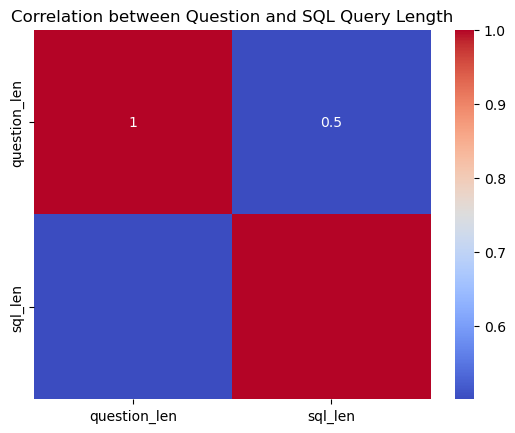

In [17]:
correlation = df_conc[['question_len', 'sql_len']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Correlation between Question and SQL Query Length")
plt.show()


### 3. Are foreign characters represented (outside of [a-zA-Z0-9])

Total Foreign Characters Found: 341805


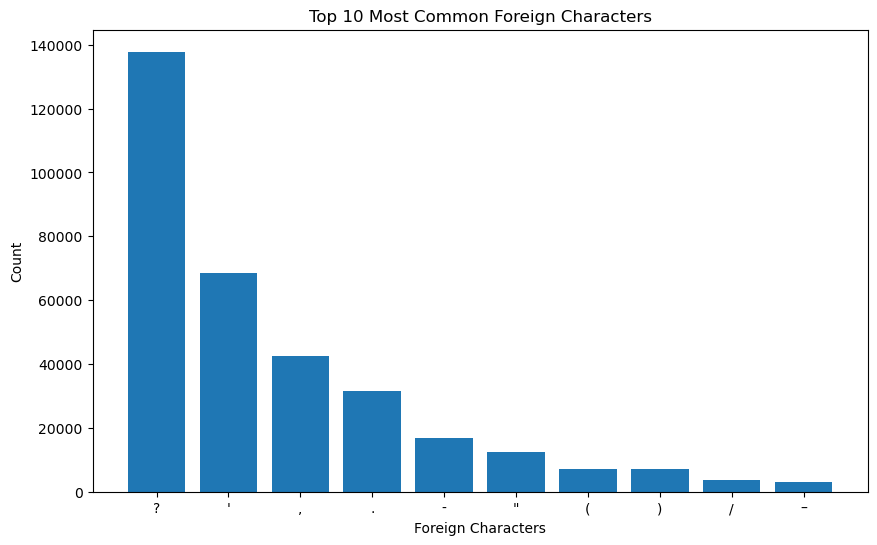

341805

In [18]:

df_conc['foreign_characters'] = df_conc['question'].apply(lambda x: re.findall(r'[^\w\s]', x))
df_conc['foreign_characters_count'] = df_conc['foreign_characters'].apply(len)
foreign_characters_total = df_conc['foreign_characters_count'].sum()
all_foreign_characters = [char for sublist in df_conc['foreign_characters'] for char in sublist]
print(f"Total Foreign Characters Found: {foreign_characters_total}")
common_characters = Counter(all_foreign_characters).most_common(10)
characters, counts = zip(*common_characters)
plt.figure(figsize=(10, 6))
plt.bar(characters, counts)
plt.title('Top 10 Most Common Foreign Characters')
plt.xlabel('Foreign Characters')
plt.ylabel('Count')
plt.show()
foreign_characters_total

# Task 5 
Explore biases in this dataset. Raise at least three concerns related to bias and write
summaries of your findings.

### Bias 1: Lack of diversity in SQL query outputs (only WHERE clauses, lack of complexity of queries)


Most common first terms in SQL Queries:
first_term
SELECT     168025
INSERT       3255
DELETE       3240
UPDATE       2850
CREATE        607
WITH          273
ALTER         134
DROP           98
(SELECT        43
select         36
Name: count, dtype: int64


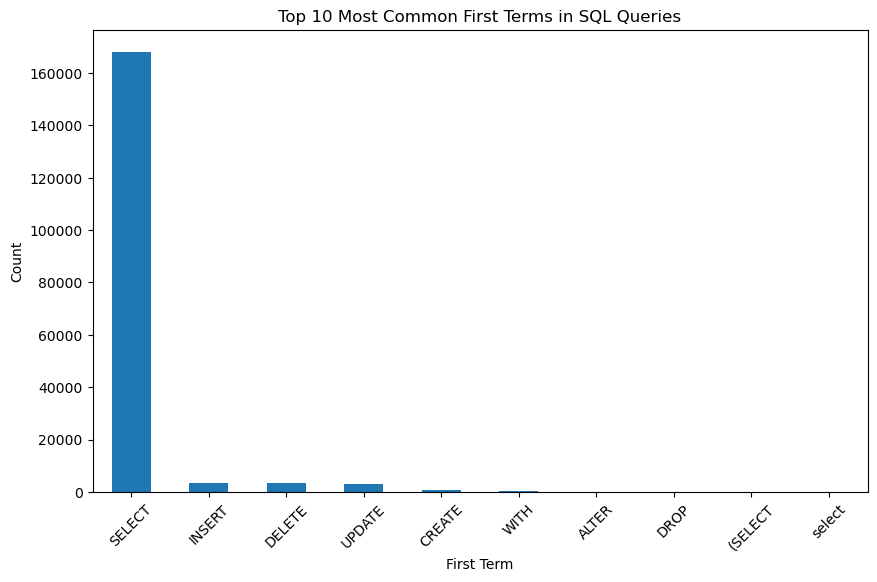

In [19]:
df_conc['first_term'] = df_conc['answer'].apply(lambda x: x.split()[0] if len(x.split()) > 0 else '')
first_term_counts = df_conc['first_term'].value_counts()
print("Most common first terms in SQL Queries:")
print(first_term_counts.head(10))
plt.figure(figsize=(10, 6))
first_term_counts.head(10).plot(kind='bar')
plt.title('Top 10 Most Common First Terms in SQL Queries')
plt.xlabel('First Term')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Bias 2: Linguistic bias (Too many english characters, or too much domain specificity)

In [20]:
def is_exclusively_foreign(text):
    return all(re.match(r'[^\x00-\x7F]', char) for char in text)
df_conc['exclusively_foreign_question'] = df_conc['question'].apply(is_exclusively_foreign)
df_conc['exclusively_foreign_answer'] = df_conc['answer'].apply(is_exclusively_foreign)
exclusively_foreign_df = df_conc[
    (df_conc['exclusively_foreign_question']) | 
    (df_conc['exclusively_foreign_answer'])
]
exclusively_foreign_df[['question', 'answer']]

,question,answer


### Bias 3: Selection bias (Not representative of queries used in the real world)

In [21]:
common_sql_keywords = ['SELECT', 'INSERT', 'UPDATE', 'DELETE', 'JOIN', 'WHERE', 'GROUP BY', 'ORDER BY']
df_conc['common_sql_pattern'] = df_conc['answer'].apply(lambda x: any(keyword in x for keyword in common_sql_keywords))
real_world_df['common_sql_pattern'] = real_world_df['SQL Query'].apply(lambda x: any(keyword in x for keyword in common_sql_keywords))
common_sql_percentage_1 = df_conc['common_sql_pattern'].mean() * 100
common_sql_percentage_2 = real_world_df['common_sql_pattern'].mean() * 100

print(f"Percentage of queries with common SQL patterns in the ensemble dataset: {common_sql_percentage_1:.2f}%")
print(f"Percentage of queries with common SQL patterns in the real world dataset: {common_sql_percentage_2:.2f}%")


Percentage of queries with common SQL patterns in the ensemble dataset: 99.68%
Percentage of queries with common SQL patterns in the real world dataset: 19.83%
